<a href="https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/dev/commented_anim_2D_flow_5_16_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DigiMat Pro: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  \partial_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

## Setup  (run this section before anything else)
#### In this section:
##### -Set up the FEniCS environment and download Paraview and some utility functions (i.e. plot_u.py) from GitHub.
##### -Import dolfin and mshr libraries.


In [ ]:
#@title
# Setup system environment and define utility functions and variables


from google.colab import files

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin


!apt-get install ffmpeg

!wget -c http://www.csc.kth.se/~jjan/digitalmath/plot_u.py
!wget -c http://www.csc.kth.se/~jjan/digitalmath/plot_u_anim.py
!wget -c http://www.csc.kth.se/~jjan/digitalmath/viz.sh
!wget -c -O ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz 'https://www.paraview.org/paraview-downloads/download.php?submit=Download&version=v5.9&type=binary&os=Linux&downloadFile=ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz'
!tar xzvf ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz --skip-old-files


Streaming output truncated to the last 5000 lines.
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/arrayscalars.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/halffloat.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/multiarray_api.txt
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/noprefix.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h
ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/lib/python3.8/site-packages/numpy/core/include/numpy/npy_3kcompat.h
ParaView-5.9.

### Import the appropriate libraries

In [ ]:
# Copyright (c) 2017-2018 Johan Jansson, Måns Andersson, Cem Degirmenci, David Kamensky, FEniCS community contributions 

import time

from dolfin import *
from mshr import *

#import matplotlib as mpl
#mpl.use('Agg')
#import matplotlib.pyplot as plt
#import dolfin.common.plotting as fenicsplot

## Define the domain
#### Here we define the geometry of our domain and generate the mesh. We wish to model a 2D system of flow around a bluff body.

#### **Below, we have provided some examples for domains to model flow around a variety of 2D objects. Choose one to generate the mesh before proceeding.**


###Flow around a circle:

In [ ]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=30 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

### Flow around a square:

In [ ]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=30 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Rectangle(Point(0.25,0.25),Point(0.75,0.75)), mresolution)

### Flow around a triangle, case 1:
##### Face of triangle is not parallel to inflow boundary

In [ ]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=75 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) -Polygon([Point(0.375,0.5), Point(0.25,0.25), Point(0.5,0.25)]), mresolution)

### Flow around a triangle, case 2:
##### Face of triangle is parallel to inflow boundary

In [ ]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=75 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) -Polygon([Point(0.25,0.5), Point(0.25,0.25), Point(0.5,0.375)]), mresolution)

## Set up the problem


#### Define the finite element spaces and functions

*   u is the velocity
*   p is the pressure



In [ ]:
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


#### Set up Boundaries


* Define the inflow velocity, $u_{in}$ 
* Mark boundary and interior regions



In [ ]:
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Marks region to the right (outside) of outflow boundary
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element()) #Marks region to the left of inflow boundary
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element()) #Marks region within inflow and outflow boundaries

#### Set stepcounter, import FEniCS, and define constants

In [ ]:
stepcounter = 0; 

from fenics import *

k = 0.1; #Timestep

nu = 1e-6; #Viscosity
d = .2*h**(3./2.); #Stabilization parameters for DFS method
t, T = 0., 2.5;  # Time interval 
gamma = 10*1./h; #Penalty parameter for weak boundary conditions
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

## Define the equations and run the code!
#### Here we define the FEniCS implementation of the DFS method defined above
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h .\end{aligned}</span></p>
</dd>

In [ ]:
while t < T: # Time-stepping loop
    print("Time step t: ", t)
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    #plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep

!rm u.pvd #remove previous file u.pvd
file = File("u.pvd") #store the solution as a VTK
uEuclidnorm = project(sqrt(inner(u, u)), Q); #solve the magnitude of the velocity at each point
uEuclidnorm.rename("Velocity", "") 
file << uEuclidnorm #Store uEuclidnorm in u.pvd as point data 
!ls u.pvd #add the file to directory


Time step t:  0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time step t:  0.1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time step t:  0.2
Time step t:  0.30000000000000004
Time step t:  0.4
Time step t:  0.5
Time step t:  0.6
Time step t:  0.7
Time step t:  0.7999999999999999
Time step t:  0.8999999999999999
Time step t:  0.9999999999999999
Time step t:  1

## Let's plot!!

  adding: u.pvd (deflated 28%)
  adding: u000000.vtu (deflated 60%)


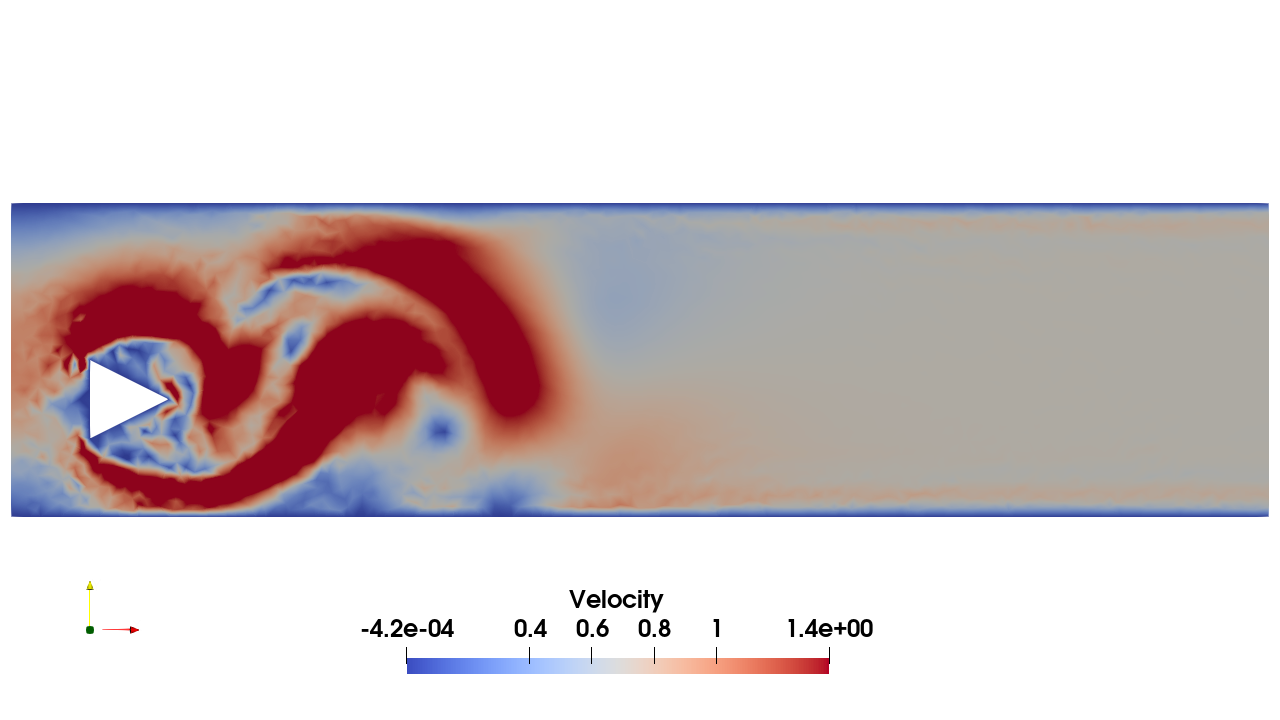

In [ ]:
!mpirun --allow-run-as-root python3 file.py

!zip u.zip u*.pvd u*vtu #create a Zip file

!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython plot_u.py


from IPython.display import Image
Image('plot_u.png')


# Karman Vortex Street!!

Time step t:  0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time step t:  0.1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time step t:  0.2
Time step t:  0.30000000000000004
Time step t:  0.4
Time step t:  0.5
Time step t:  0.6
Time step t:  0.7
Time step t:  0.7999999999999999
Time step t:  0.8999999999999999
Time step t:  0.9999999999999999
Time step t:  1.0999999999999999
Time step t:  1.2
Time step t:  1.3
Time step t:  1.4000000000000001
Time step t:  1.5000000000000002
Time step t:  1.6000000000000003
Time step t:  1.7000000000000004
Time step t:  1.8000000000000005
Time step t:  1.9000000000000006
Time step t:  2.0000000000000004
Time step t:  2.1000000000000005
Time step t:  2.2000000000000006
Time step t:  2.3000000000000007
Time step t:  2.400000000000001
Time step t:  2.500000000000001
Time step t:  

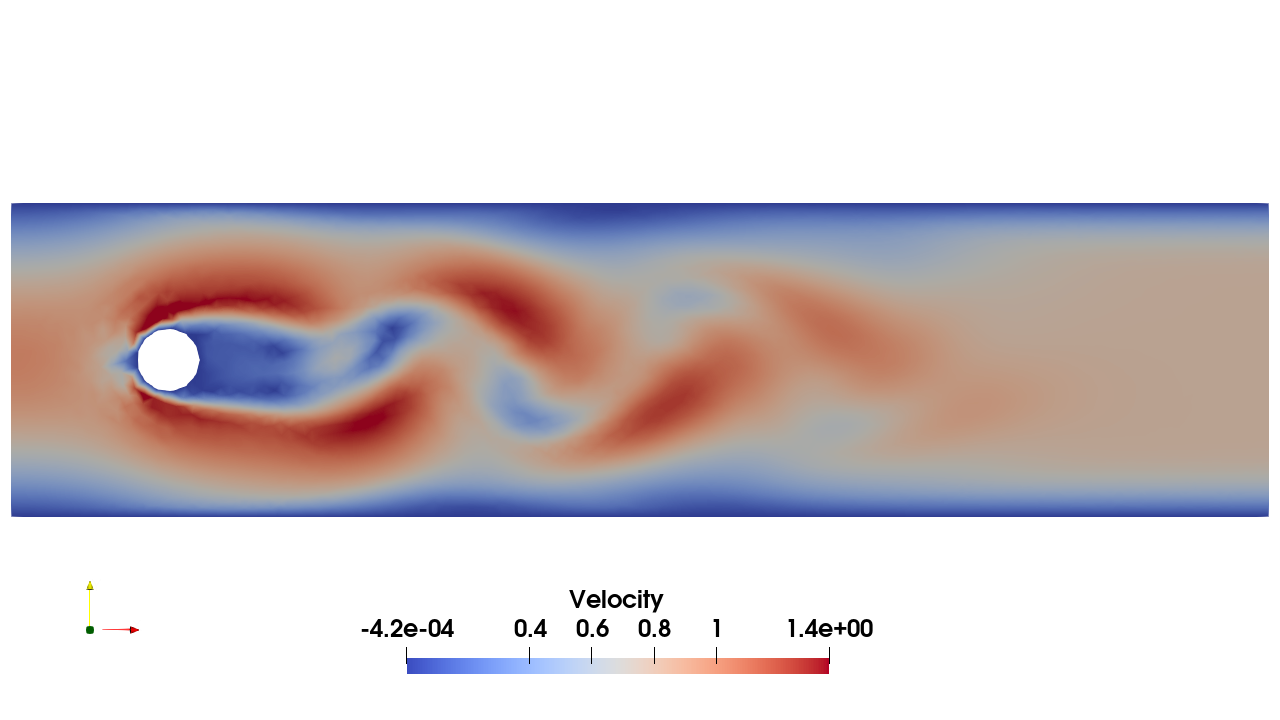

In [ ]:

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=75 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Marks region to the right (outside) of outflow boundary
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element()) #Marks region to the left of inflow boundary
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element()) #Marks region within inflow and outflow boundaries


stepcounter = 0; 

from fenics import *

k = 0.1; #Timestep

nu = 1e-3; #Viscosity
d = .2*h**(3./2.); #Stabilization parameters for DFS method
t, T = 0., 4;  # Time interval 
gamma = 10*1./h; #Penalty parameter for weak boundary conditions
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

while t < T: # Time-stepping loop
    print("Time step t: ", t)
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    #plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep

!rm u.pvd #remove previous file u.pvd
file = File("u.pvd") #store the solution as a VTK
uEuclidnorm = project(sqrt(inner(u, u)), Q); #solve the magnitude of the velocity at each point
uEuclidnorm.rename("Velocity", "") 
file << uEuclidnorm #Store uEuclidnorm in u.pvd as point data 
!ls u.pvd #add the file to directory



!mpirun --allow-run-as-root python3 file.py

!zip u.zip u*.pvd u*vtu #create a Zip file

!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython plot_u.py


from IPython.display import Image
Image('plot_u.png')



# Animation

In [ ]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=75 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Marks region to the right (outside) of outflow boundary
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element()) #Marks region to the left of inflow boundary
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element()) #Marks region within inflow and outflow boundaries


stepcounter = 0; 

from fenics import *

k = 0.1; #Timestep

nu = 1e-3; #Viscosity
d = .2*h**(3./2.); #Stabilization parameters for DFS method
t, T = 0., 10;  # Time interval 
gamma = 10*1./h; #Penalty parameter for weak boundary conditions
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

file = File("u.pvd") #store the solution as a VTK

while t < T: # Time-stepping loop
    print("Time step t: ", t)
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    #plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    u_out = project(u, V); #solve the magnitude of the velocity at each point
    u_out.rename("Velocity", "") 
    file << u_out;
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep


!rm plot_u_anim.py
!wget -c http://www.csc.kth.se/~jjan/digitalmath/plot_u_anim.py 1>wlog1 2>wlog2

!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython plot_u_anim.py
!ffmpeg -y -r 16 -f image2 -s 1280x720 -i "test.%04d.png" -vcodec libx264 -crf 25  -pix_fmt yuv420p movie2.mp4 1>vlog1 2>vlog2
!cp movie2.mp4 /usr/local/share/jupyter/nbextensions/
#from IPython.display import Image
#Image('plot_u.png')
from IPython.core.display import display, HTML
display(HTML("""
<video autoplay loop width=640 height=360 src="nbextensions/movie2.mp4"</video>
"""
))



Time step t:  0.0
Time step t:  0.1
Time step t:  0.2
Time step t:  0.30000000000000004
Time step t:  0.4
Time step t:  0.5
Time step t:  0.6
Time step t:  0.7
Time step t:  0.7999999999999999
Time step t:  0.8999999999999999
Time step t:  0.9999999999999999
Time step t:  1.0999999999999999
Time step t:  1.2
Time step t:  1.3
Time step t:  1.4000000000000001
Time step t:  1.5000000000000002
Time step t:  1.6000000000000003
Time step t:  1.7000000000000004
Time step t:  1.8000000000000005
Time step t:  1.9000000000000006
Time step t:  2.0000000000000004
Time step t:  2.1000000000000005
Time step t:  2.2000000000000006
Time step t:  2.3000000000000007
Time step t:  2.400000000000001
Time step t:  2.500000000000001
Time step t:  2.600000000000001
Time step t:  2.700000000000001
Time step t:  2.800000000000001
Time step t:  2.9000000000000012
Time step t:  3.0000000000000013
Time step t:  3.1000000000000014
Time step t:  3.2000000000000015
Time step t:  3.3000000000000016
Time step t:  3.4